Investigating the mesh artificacts.... 



In [89]:
import os, yt, numpy as np
import xmltodict, meshio 

In [90]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','../'),'edc_driven_convection_madagascar',
                     'edc_driven_convection_madagascar','solution')

In [91]:
import xmltodict,meshio,os, numpy as np
class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']        
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 
        mesh_names=[]
        con_offset=-1
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.
            mesh_names.append(mesh_name)
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
        self.mesh_names=mesh_names
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 

        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['hexahedron'] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name,coords)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name,coords):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}       
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=np.reshape(point_data[nm][:,component],conn_shp)
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=np.reshape(point_data[nm],conn_shp)
                    
        crdHash={0:'x_i',1:'y_i',2:'z_i'}
        for coord_i,coord_name in crdHash.items(): 
            m_F=(mesh_name,coord_name) # e.g., ('connect1','velocity_cx')
            node_data[m_F]=np.reshape(coords[:,coord_i],conn_shp)                
    
        return node_data      


In [92]:
pFile=os.path.join(DataDir,'solution-00015.pvtu')
pvuData=pvuFile(pFile)
pvuData.load()

In [98]:
def _newz(field,data):
#     return data["z"]
    return data["index", "z"]

# yt.add_field(("all","newz"),
#              function=_newz,
#              units="m")

for msh in pvuData.mesh_names:
    yt.add_field((msh,"newz"),function=_newz,units="m",force_override=True)


In [100]:
ds4 = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)  

yt : [INFO     ] 2020-06-29 13:48:37,324 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-06-29 13:48:37,324 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-06-29 13:48:37,325 Parameters: domain_left_edge          = [ 2679220.40116885  2679220.40116884 -3272029.00399254]
yt : [INFO     ] 2020-06-29 13:48:37,325 Parameters: domain_right_edge         = [5653600.91489411 5653600.91489411 -736270.69874229]
yt : [INFO     ] 2020-06-29 13:48:37,326 Parameters: cosmological_simulation   = 0.0


In [101]:
p=yt.SlicePlot(ds4, "z", ("all", "newz"))
p.show()

YTFieldTypeNotFound: Could not find field type 'index'.

In [6]:
# try a pass through.... 
@yt.derived_field(name = ("z_passthrough"))
def z_passthrough(field, data):
    return data["index", "z"]

# yt.add_field(("all", "z_passthrough"), function=z_passthrough, units="m")
# hmm, https://yt-project.org/doc/developing/creating_derived_fields.html 
p=yt.SlicePlot(ds4, "z", ("all", "z_passthrough"))
p.set_log("z_passthrough",False)
p.show()

/home/chavlin/miniconda3/envs/sandbox/lib/python3.6/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


YTFieldNotFound: Could not find field '('all', 'z_passthrough')' in UnstructuredMeshData.

In [7]:
dir(ds4.index.ds.fields)
ds4.fields
# type(ds4.index)
# ds4.index.z

yt : [INFO     ] 2020-06-29 11:24:37,475 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:37,475 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:37,476 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:37,476 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:37,481 Making a fixed resolution buffer of (('all', 'z_i')) 800 by 800
yt : [WARNING  ] 2020-06-29 11:24:37,766 Plot image for field ('all', 'z_i') has no positive values.  Max = -1851051.790326.
yt : [WARNING  ] 2020-06-29 11:24:37,766 Switching to linear colorbar scaling.



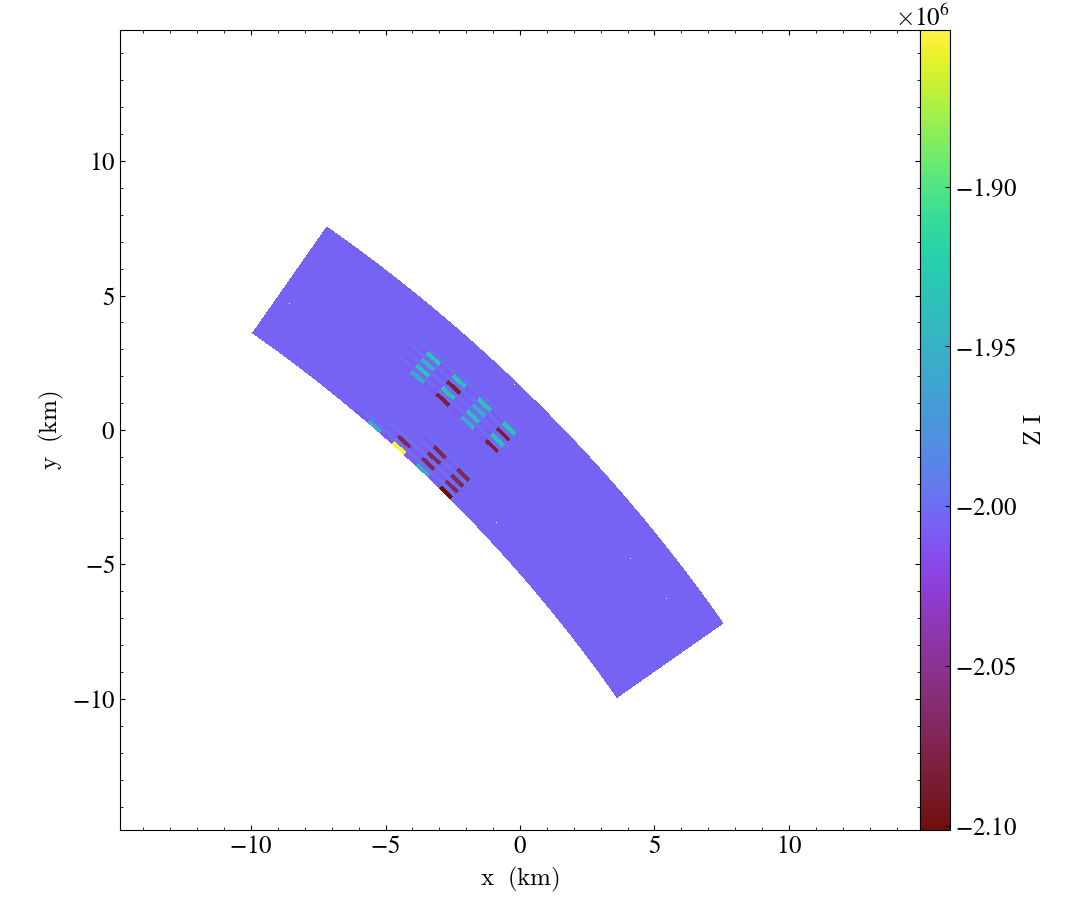

In [8]:
# plot z the bad way
p=yt.SlicePlot(ds4, "z", ("all", "z_i"))
p.set_log("z_i",False)
p.show()

yt : [INFO     ] 2020-06-29 11:24:38,711 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:38,712 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:38,712 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:38,713 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:24:38,714 Making a fixed resolution buffer of (('all', 'x_i')) 800 by 800



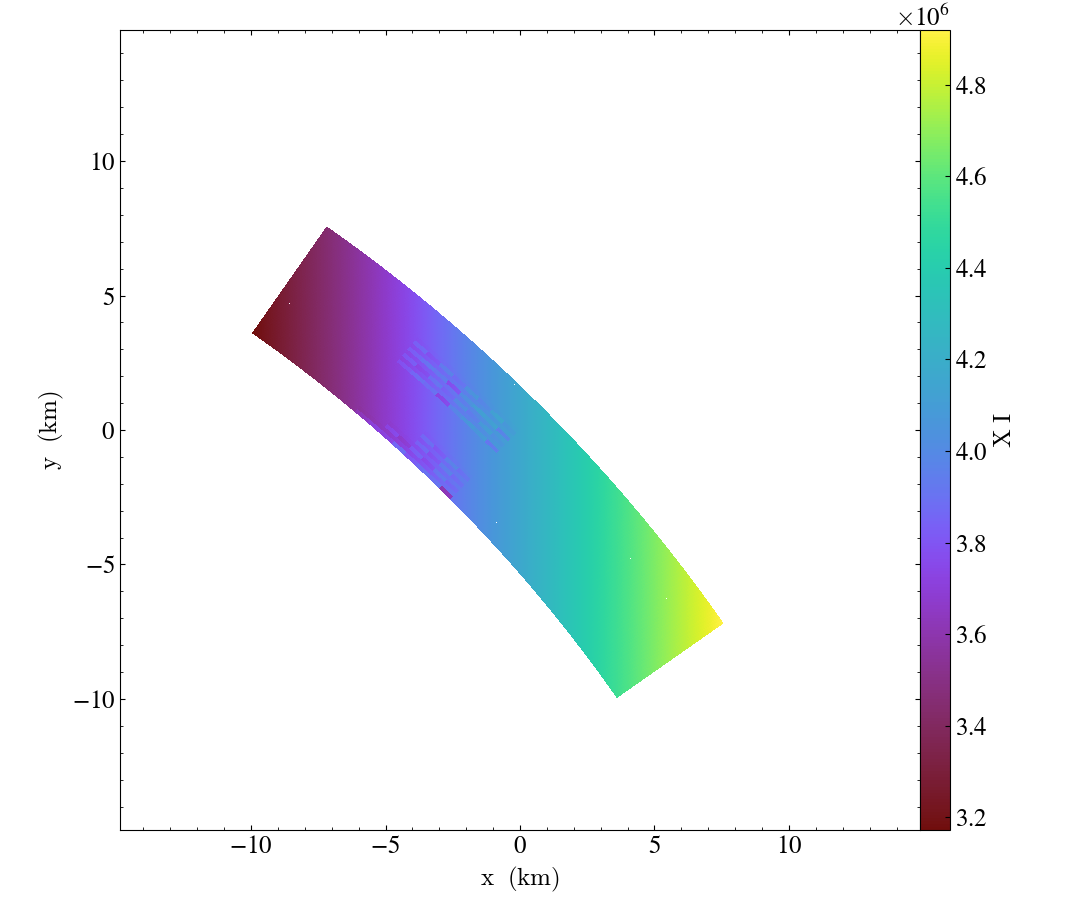

In [9]:
p=yt.SlicePlot(ds4, "z", ("all", "x_i"))
p.set_log("x_i",False)
p.show()


In [10]:
pvuData.connectivity[0]

array([[     0,      1,      3, ...,      5,      7,      6],
       [     8,      9,     11, ...,     13,     15,     14],
       [    16,     17,     19, ...,     21,     23,     22],
       ...,
       [139880, 139881, 139883, ..., 139885, 139887, 139886],
       [139888, 139889, 139891, ..., 139893, 139895, 139894],
       [139896, 139897, 139899, ..., 139901, 139903, 139902]])

## Issue (?) 1
within single .vtu file, sometimes connectivity points to indeces outside coord array 

In [11]:
# pull out a single processor .vtu file 
sFile=pvuData.pXML['VTKFile']['PUnstructuredGrid']['Piece'][0]['@Source']
sFile=os.path.join(DataDir,sFile)
print(sFile)
meshPiece=meshio.read(sFile) # read it in with meshio     
coords=meshPiece.points # coords and node_data are already global
connectivity=meshPiece.cells_dict['hexahedron'] # 2D connectivity array 

/home/chavlin/hdd/data/yt_dev/aspect/edc_driven_convection_madagascar/edc_driven_convection_madagascar/solution/solution-00015.0000.vtu


In [12]:
 connectivity.shape

(17480, 8)

In [13]:
connectivity.size

139840

In [14]:
coords.shape

(139840, 3)

size of connectivity is length of first dim in coords -- makes sense! the value of each element in connectivity shoudl be the index in coords, giving the x-y-z position of that vertex... but in some .vtu files, we see: 

In [15]:
coords[connectivity.ravel()]

IndexError: index 139840 is out of bounds for axis 0 with size 139840

In [16]:
connectivity.max()

139903

so values in connectivity exceed the length of coords! 

In [17]:
connectivity[connectivity>coords.shape[0]].size

63

In [18]:
connectivity[connectivity>coords.shape[0]]

array([139841, 139843, 139842, 139844, 139845, 139847, 139846, 139848,
       139849, 139851, 139850, 139852, 139853, 139855, 139854, 139856,
       139857, 139859, 139858, 139860, 139861, 139863, 139862, 139864,
       139865, 139867, 139866, 139868, 139869, 139871, 139870, 139872,
       139873, 139875, 139874, 139876, 139877, 139879, 139878, 139880,
       139881, 139883, 139882, 139884, 139885, 139887, 139886, 139888,
       139889, 139891, 139890, 139892, 139893, 139895, 139894, 139896,
       139897, 139899, 139898, 139900, 139901, 139903, 139902],
      dtype=int32)

So where do these point to?? Presumably, a different .vtu file, but how do we know which one? `GhostLevel=0` in all these .vtu files, so wouldn't expect multiple references to vertices... but.... ? 

When assembling the .vtu files, we don't error because the coordinates array becomes a **global** array. Furthermore, this only seems to happen in the processor 0 .vtu files, so maybe these are global index references already. But since I have to offset the indeces between connectivity arrays for each vtu, maybe it's offsetting these incorrectly.

## Issue 2 (?) : reshaping field_data

The field data input for `yt.load_unstructured_mesh` needs to match the shape of the connectivity array. 

In [19]:
T=meshPiece.point_data['T']

In [20]:
T.shape

(139840,)

In [21]:
connectivity.shape

(17480, 8)

In [22]:
connectivity.size

139840

Naive approach is to just reshape T:

In [23]:
Trsh=T.reshape(connectivity.shape)

In [24]:
Trsh.shape

(17480, 8)

**but** the connectivity array does not increase monotonically! 

In [25]:
connectivity[0:3]

array([[ 0,  1,  3,  2,  4,  5,  7,  6],
       [ 8,  9, 11, 10, 12, 13, 15, 14],
       [16, 17, 19, 18, 20, 21, 23, 22]], dtype=int32)

In [26]:
T[0:24]

array([1840.6965332 , 1837.11938477, 1842.52648926, 1838.94946289,
       1841.03149414, 1837.45446777, 1842.80651855, 1839.62426758,
       1837.11938477, 1833.5423584 , 1838.94946289, 1835.37243652,
       1837.45446777, 1833.87744141, 1839.62426758, 1836.03491211,
       1842.52648926, 1838.94946289, 1844.88146973, 1841.30444336,
       1842.80651855, 1839.62426758, 1845.2364502 , 1842.62438965])

Just reshaping would swap the values for the final two vertices in each hexahedron element. i.e., : 

In [27]:
connectivity[0,6]

7

In [28]:
connectivity[0,7]

6

In [29]:
T[connectivity[0,6]]

1839.624267578125

In [30]:
T[connectivity[0,7]]

1842.8065185546875

In [31]:
Trsh[0,6]

1842.8065185546875

In [32]:
Trsh[0,7]

1839.624267578125

The solution would be to evaluate THEN reshape, i.e., 

In [33]:
T[connectivity.ravel()].reshape(connectivity.shape)

IndexError: index 139840 is out of bounds for axis 0 with size 139840

but we hit issue 1 again... 

we could always just swap the columns after reshaping... but this will be unstable for other datasets. Bad to assume these columns will always be reversed. but it would work:

In [34]:
import copy
Trsh2=copy.deepcopy(Trsh)
Col_6=copy.deepcopy(Trsh2[:,6])

In [35]:
Trsh2[:,6]=Trsh2[:,7]

In [36]:
Trsh2[:,7]=Col_6

In [37]:
Trsh2[0,6]

1839.624267578125

In [40]:
T[connectivity[0,6]]

1839.624267578125

In [41]:
Trsh2[0,7]

1842.8065185546875

In [43]:
T[connectivity[0,7]]

1842.8065185546875

In [46]:
import xmltodict,meshio,os, numpy as np
class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']        
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):    
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
            
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 

        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['hexahedron'] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name,coords)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name,coords):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            Rsh=np.reshape(data1d,conn_shp)
            Col6=copy.deepcopy(Rsh[:,6])
            Rsh[:,6]=Rsh[:,7]
            Rsh[:,7]=Col6
            return Rsh
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=rshpData(point_data[nm][:,component])
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=rshpData(point_data[nm])
                    
        crdHash={0:'x_i',1:'y_i',2:'z_i'}
        for coord_i,coord_name in crdHash.items(): 
            m_F=(mesh_name,coord_name) # e.g., ('connect1','velocity_cx')
            node_data[m_F]=rshpData(coords[:,coord_i])
            
    
        return node_data      


yt : [INFO     ] 2020-06-29 11:29:48,465 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-06-29 11:29:48,465 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-06-29 11:29:48,466 Parameters: domain_left_edge          = [ 2679220.40116885  2679220.40116884 -3272029.00399254]
yt : [INFO     ] 2020-06-29 11:29:48,466 Parameters: domain_right_edge         = [5653600.91489411 5653600.91489411 -736270.69874229]
yt : [INFO     ] 2020-06-29 11:29:48,467 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2020-06-29 11:29:48,636 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:29:48,636 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:29:48,637 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:29:48,637 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:29:48,638 Making a fixed resolution buffer of (('all', 'z_i')) 800 by 800
yt : [WARNING  ] 2020-06-29 11:29:49,205 Plot image f


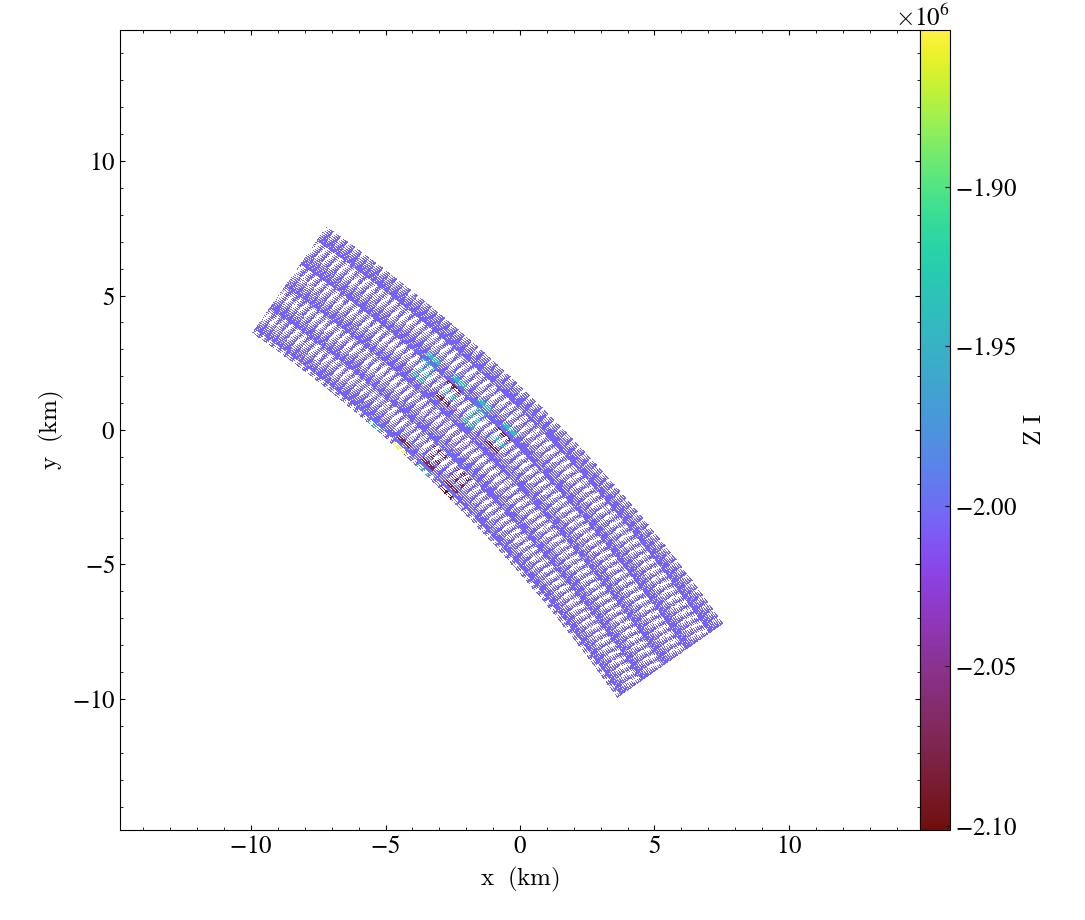

In [47]:
pFile=os.path.join(DataDir,'solution-00015.pvtu')
pvuData=pvuFile(pFile)
pvuData.load()

ds5 = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data
)  


p=yt.SlicePlot(ds5, "z", ("all", "z_i"))
p.set_log("z_i",False)
p.show()

lol. not sure what happened there.... maybe `load_unstructured_mesh` handles this internally somehow. In any case, the checkerboarding is still there. 

yt : [INFO     ] 2020-06-29 11:31:36,419 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:31:36,420 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:31:36,420 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:31:36,421 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:31:36,421 Making a fixed resolution buffer of (('all', 'velocity_inclination')) 800 by 800
yt : [WARNING  ] 2020-06-29 11:31:36,984 Plot image for field ('all', 'velocity_inclination') has both positive and negative values. Min = -88.904761, Max = 89.259856.
yt : [WARNING  ] 2020-06-29 11:31:36,985 Switching to symlog colorbar scaling unless linear scaling is specified later



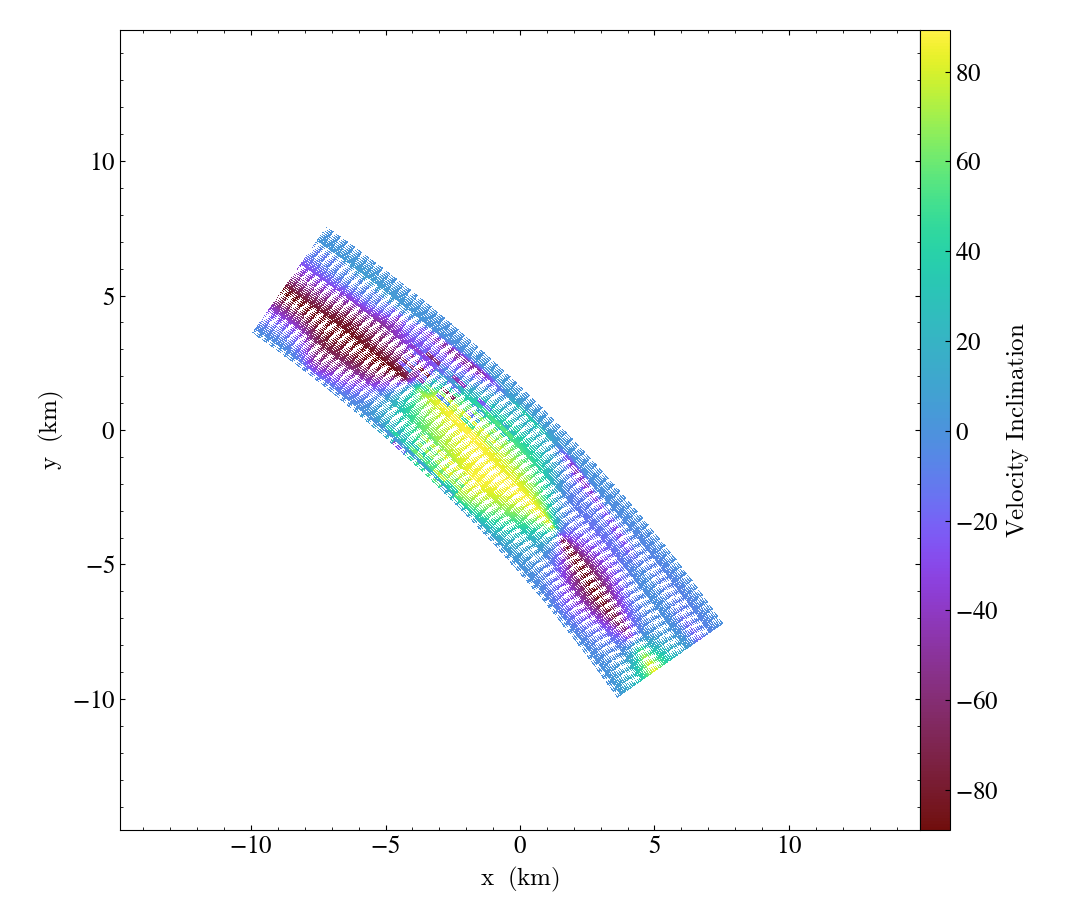

In [48]:
p=yt.SlicePlot(ds5, "z", ("all", "velocity_inclination"))
p.set_log("velocity_inclination",False)
p.show()

In [74]:
# this version: global concatenation of all .vtus into a single "connect1" mesh, 
# reshape after the global concat with row swapping. 
# connectivity offset only for connectivity values within the coord range of each .vtu 
import xmltodict,meshio,os, numpy as np
class pvuGlobalFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']        
            
    def load(self):                      
    
        conlist=[]  # 2D global connectivity array
        coordlist=[] # global, concatenated coordinate array 
        node_vals={} # global, concatenated field data

        con_offset=-1
        mesh_name="connect1"
        for mesh_id,src in enumerate(self.pXML['VTKFile']['PUnstructuredGrid']['Piece']):                
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
#             con_offset=con.max() 
            con_offset=con_offset+con.size
            
            
            conlist.extend(con.astype("i8"))
            
            
            coordlist.extend(coord.astype("f8"))
            
            for fiel,vals in node_d.items():
                if fiel not in node_vals.keys():
                    node_vals[fiel]=[]                    
                node_vals[fiel].extend(node_d[fiel])
                
        coordlist=np.array(coordlist)        
        conlist=np.array(conlist)        
        
        # reshape the field data, swap cols after adding z_i               
        node_vals[(mesh_name,'z_i')]=copy.deepcopy(coordlist[:,2])                
        node_vals[(mesh_name,'y_i')]=copy.deepcopy(coordlist[:,1])                
        node_vals[(mesh_name,'x_i')]=copy.deepcopy(coordlist[:,0])  
        for fiel,vals in node_vals.items():
            node_vals[fiel]=np.array(vals).reshape(conlist.shape)
            col6=copy.deepcopy(node_vals[fiel][:,6])
            node_vals[fiel][:,6]=node_vals[fiel][:,7]
            node_vals[fiel][:,7]=col6
            
        self.connectivity=conlist
        self.coordinates=coordlist
        self.node_data=node_vals
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 

        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        connectivity=meshPiece.cells_dict['hexahedron'] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name,coords)

        # offset the connectivity matrix to global value 
        # keep potential global references!
#         connectivity=np.array(connectivity)+connectivity_offset
        connectivity=np.array(connectivity)
        connectivity[connectivity<coords.shape[0]]=connectivity[connectivity<coords.shape[0]]+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name,coords):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}       
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=point_data[nm][:,component]
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=point_data[nm]                               
    
        return node_data      


In [75]:

pvuDataG=pvuGlobalFile(pFile)
pvuDataG.load()

ds6 = yt.load_unstructured_mesh(
    pvuDataG.connectivity,
    pvuDataG.coordinates,
    node_data = pvuDataG.node_data
)  


yt : [INFO     ] 2020-06-29 11:57:43,108 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-06-29 11:57:43,109 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-06-29 11:57:43,109 Parameters: domain_left_edge          = [ 2679220.40116885  2679220.40116884 -3272029.00399254]
yt : [INFO     ] 2020-06-29 11:57:43,109 Parameters: domain_right_edge         = [5653600.91489411 5653600.91489411 -736270.69874229]
yt : [INFO     ] 2020-06-29 11:57:43,110 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2020-06-29 11:58:00,075 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:00,076 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:00,077 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:00,077 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:00,078 Making a fixed resolution buffer of (('connect1', 'z_i')) 800 by 800
yt : [WARNING  ] 2020-06-29 11:58:00,358 Plot image for field ('connect1', 'z_i') has no positive values.  Max = -839514.507844.
yt : [WARNING  ] 2020-06-29 11:58:00,359 Switching to linear colorbar scaling.



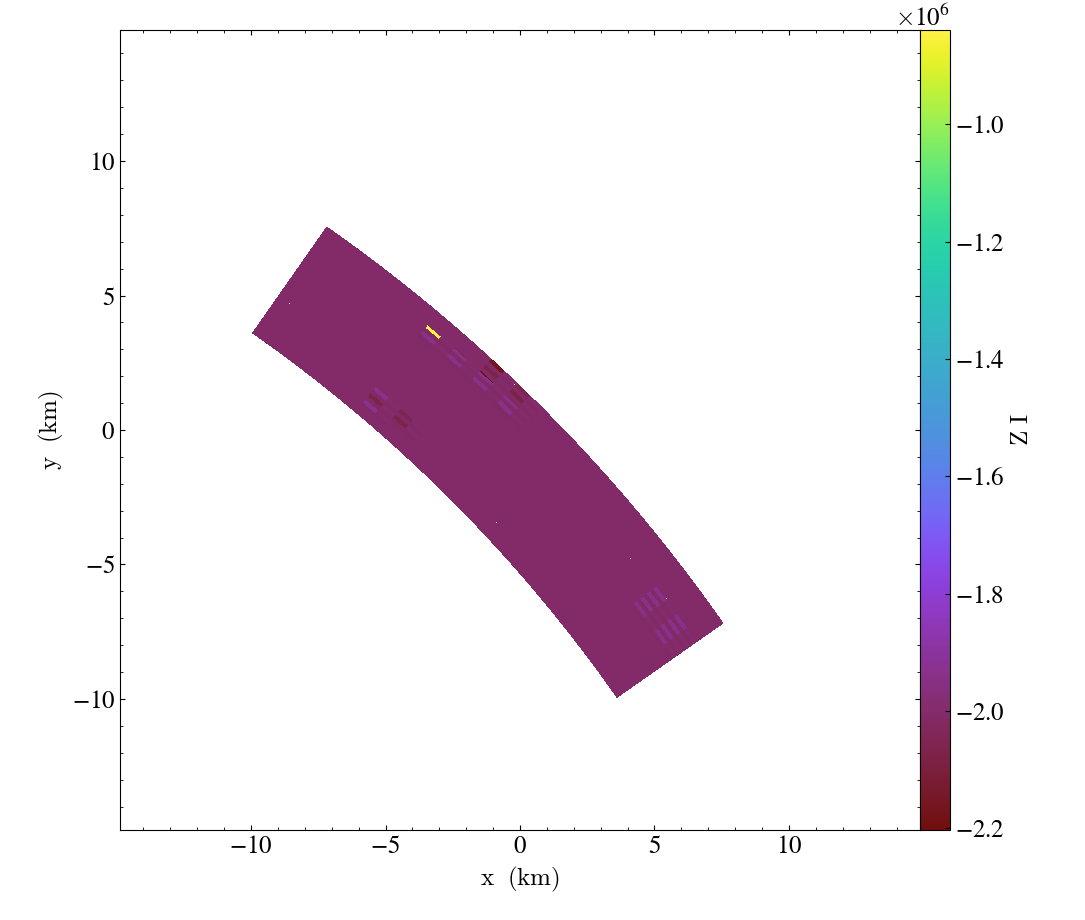

In [77]:
p=yt.SlicePlot(ds6, "z", ("connect1", "z_i"))
p.set_log("z_i",False)
p.show()

yt : [INFO     ] 2020-06-29 11:58:04,382 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:04,383 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:04,384 xlim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:04,384 ylim = 2679220.401169 5653600.914894
yt : [INFO     ] 2020-06-29 11:58:04,385 Making a fixed resolution buffer of (('connect1', 'x_i')) 800 by 800



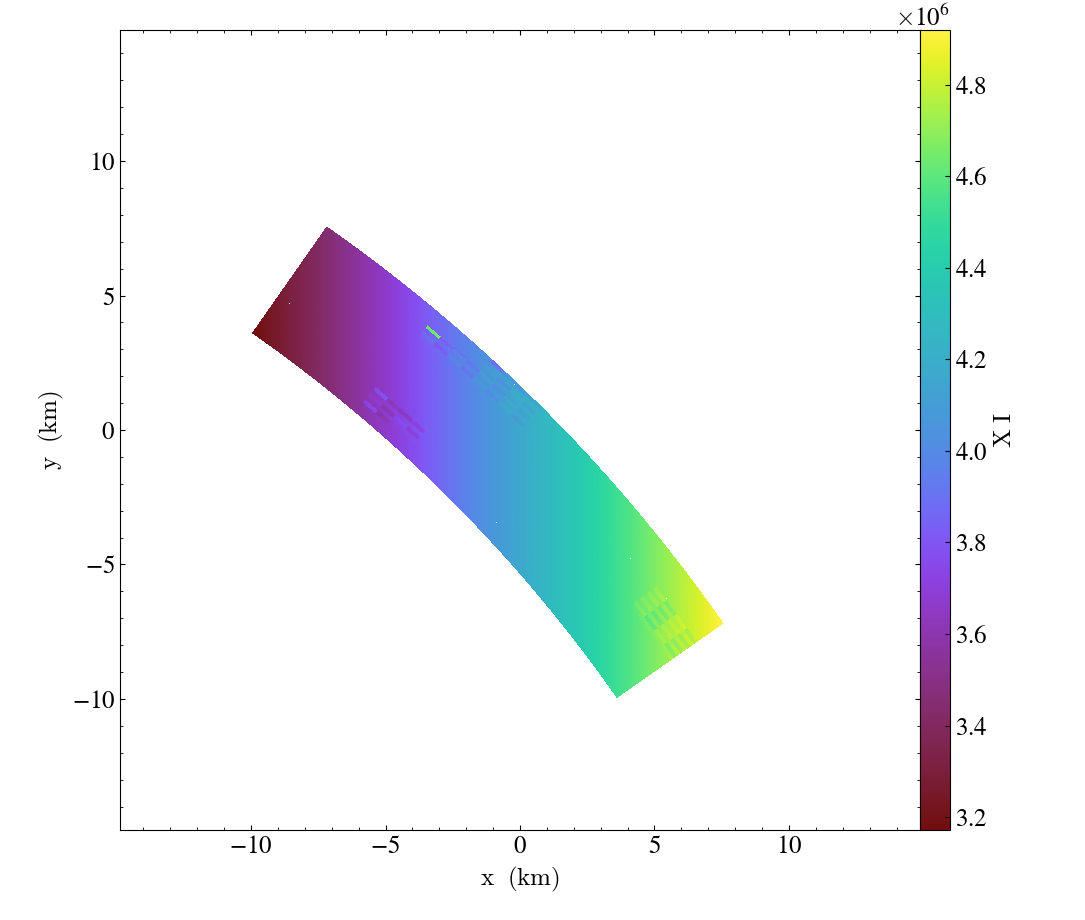

In [78]:
p=yt.SlicePlot(ds6, "z", ("connect1", "x_i"))
p.set_log("x_i",False)
p.show()

still some errors.... generally lower range though?